In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),transforms.Resize((224,224)),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 10

train_data = torchvision.datasets.ImageFolder(root = 'drive/MyDrive/Colab Notebooks/mask_dataset/train', transform=transform )
test_data = torchvision.datasets.ImageFolder(root = 'drive/MyDrive/Colab Notebooks/mask_dataset/test', transform=transform )

train_loader = torch.utils.data.DataLoader(train_data,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=2)

test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          num_workers=2)


In [3]:
def find_key(dict, val):
  return next(key for key, value in dict.items() if value == val)

find_key(train_data.class_to_idx,0)

'mask'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


no_mask
94


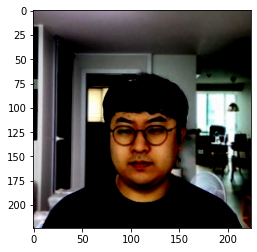

In [4]:
train =  iter(train_loader)
images, label = train.next()
images[2].numpy()
plt.imshow(np.transpose(images[2],(1,2,0)))
print(find_key(train_data.class_to_idx,label[2]))
print(len(train_loader))

In [5]:
if torch.cuda.is_available():
  device = torch.device('cuda')
else :
  device = torch.device('cpu')
print(device)

cuda


In [ ]:
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [ ]:
class ResNet(nn.Module):
    def __init__(self, num_classes=5):
        super(ResNet, self).__init__()
        self.in_planes = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(16, 2, stride=1)
        self.layer2 = self._make_layer(32, 2, stride=2)
        self.layer3 = self._make_layer(64, 2, stride=2)
        self.linear = nn.Linear(64*7*7, num_classes)

    def _make_layer(self, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(BasicBlock(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 8)
        out = torch.flatten(out, 1)
        out = self.linear(out)
        return out

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            #3x112x112
            nn.Conv2d(3,64,3, padding = 1),nn.ReLU(),
            nn.Conv2d(64,64,3, padding = 1),nn.ReLU(),
            nn.MaxPool2d(2,2),
            #64x56x56
            nn.Conv2d(64,128,3,padding = 1),nn.ReLU(),
            nn.Conv2d(128,128,3,padding = 1),nn.ReLU(),
            nn.MaxPool2d(2,2),
            #128x28x28
            nn.Conv2d(128,128,3,padding = 1),nn.ReLU(),
            nn.MaxPool2d(2,2),
            #256x14x14
        )
        self.fc1 = nn.Linear(128*14*14,4096)
        self.fc2 = nn.Linear(4096,1000)
        self.fc3 = nn.Linear(1000,5)

    def forward(self, x):
        x = self.conv(x)
        x = torch.flatten(x,1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [ ]:
net = Net().to('cuda')

# **Pretrained Model**

In [6]:
from torchvision import models

In [ ]:
pretrained_vgg = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


In [8]:
pretrained_resnet = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


In [20]:
pretrained_mobilenet = models.mobilenet_v2(pretrained=True)

In [21]:
print(device)
num_classes = 2

cuda


In [ ]:
pretrained_vgg.classifier[6] = nn.Linear(4096,num_classes)

pretrained_vgg.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [10]:
inplane = pretrained_resnet.fc.in_features
pretrained_resnet.fc = nn.Linear(inplane, num_classes)
pretrained_resnet.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [22]:
pretrained_mobilenet.classifier[1] = nn.Linear(1280,num_classes)
pretrained_mobilenet.to(device)

MobileNetV2(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momen

# **모델요약**

In [29]:
from torchsummary import summary

summary(pretrained_mobilenet, input_size=(3, 224, 224), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

In [23]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pretrained_mobilenet.parameters(), lr=0.001)

In [24]:

count = 0
for epoch in range(1):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        pretrained_mobilenet.train()
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = pretrained_mobilenet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()

        if i % 10 == 9:    # print every 2000 mini-batches
          print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
          running_loss = 0.0

print('Finished Training')

[1,    10] loss: 0.016
[1,    20] loss: 0.004


KeyboardInterrupt: ignored

## **모델의 저장**

In [14]:
PATH = 'drive/MyDrive/Colab Notebooks/'

torch.save(pretrained_resnet.state_dict(), PATH + 'mask_resnet_state_dict.pt')  # 모델 객체의 state_dict 저장

In [17]:

pretrained_resnet.load_state_dict(torch.load(PATH + 'mask_resnet_state_dict.pt'))  # state_dict를 불러 온 후, 모델에 저장

<All keys matched successfully>

In [25]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
      pretrained_mobilenet.eval()
      images, labels = data
      images, labels = images.to(device), labels.to(device)
      # calculate outputs by running images through the network
      outputs = pretrained_mobilenet(images)
      # the class with the highest energy is what we choose as prediction
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 100 %


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


no_mask


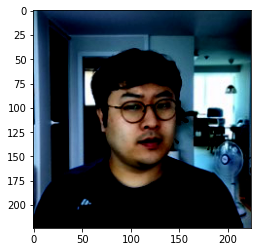

In [16]:
with torch.no_grad():
  pretrained_mobilenet.eval()
  single_x = test_data[100][0]
  plt.imshow(np.transpose(single_x,(1,2,0)))
  
  single_x = single_x.unsqueeze(0)
  #X_single_data = mnist_test.test_data[r:r + 1].view(-1, 28 * 28).float().to(device)
  #Y_single_data = mnist_test.test_labels[r:r + 1].to(device)
  outputs = pretrained_mobilenet(single_x.to(device))

  print(find_key(test_data.class_to_idx,torch.argmax(outputs)))

In [17]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      //await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [18]:
import cv2
from google.colab.patches import cv2_imshow
from IPython.display import Image

In [27]:
while(True):
  with torch.no_grad():
    image = take_photo()
    #display(Image(image))
    image = cv2.imread(image)
    cv2_imshow(image)
    image = transform(image)
    pretrained_mobilenet.eval()
    single_x = image.reshape(3,224,224)
    #print(single_x.shape)
    single_x = single_x.unsqueeze(0)
    #print(single_x.shape)
    
    outputs = pretrained_mobilenet(single_x.to(device))

    print(find_key(test_data.class_to_idx,torch.argmax(outputs)))

Output hidden; open in https://colab.research.google.com to view.